In [1]:
## import libraries
import os
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers 
from scipy.optimize import curve_fit
import numpy as np
import time
from sklearn.metrics import mean_squared_log_error
import levenberg_marquardt as lm

os.chdir('../')
warnings.filterwarnings('ignore')

In [2]:
tensorflow.__version__

'2.19.0'

In [3]:
demand_training_path = r'E:\Projects Kgp\IIM Mumbai Task\Facility_layout_optimization\ResearchData\3.TrainingTable.csv'
demand_distribution_path = r'E:\Projects Kgp\IIM Mumbai Task\Facility_layout_optimization\ResearchData\1.Demand_Distribution.csv'


In [4]:
data = pd.read_csv(demand_training_path)
demand = pd.read_csv(demand_distribution_path)

In [5]:
data.sample(5)

,Delivery_Norm,Shipping_Norm,Damage_rate_Norm,Population_Norm,Employment_Norm,Salary_Norm,Pnum
293,0.232704,0.625,0.756502,0.060094,0.130484,0.505831,452
271,0.389937,0.875,0.925589,0.130841,0.453491,0.551409,628
145,0.169811,0.625,0.790206,0.261225,0.485363,0.342743,1767
266,0.339623,0.750,0.856904,0.120447,0.820694,0.316739,651
60,0.220126,0.625,0.767445,0.322514,0.267948,0.744314,3970


In [6]:
demand.sample(5)

,Index,Demand,Latitude,Longitude
153,153,1423,36.585455,109.489727
361,361,8,34.471431,100.244809
135,135,1968,30.199652,115.038520
67,67,3351,30.335165,112.239741
313,313,299,24.403582,111.566694


In [7]:
data


,Delivery_Norm,Shipping_Norm,Damage_rate_Norm,Population_Norm,Employment_Norm,Salary_Norm,Pnum
0,0.006289,0.208333,0.361548,1.000000,0.495541,0.870605,101570
1,0.006289,0.000000,0.856904,0.843071,0.251620,0.966487,71683
2,0.251572,0.625000,0.756064,0.830920,0.137091,0.623857,66496
3,0.000000,0.166667,0.293265,0.811754,0.104655,0.477629,36100
4,0.352201,0.791667,0.890161,0.608333,0.362364,0.932828,33770
...,...,...,...,...,...,...,...
366,0.389937,0.875000,0.896701,0.064510,0.094021,0.154905,3
367,0.937107,1.000000,0.985118,0.174495,0.888984,0.211847,3
368,0.641509,1.000000,0.972424,0.023679,0.075443,0.493849,2
369,1.000000,1.000000,0.932593,0.226672,0.301334,0.288815,1


In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data[['Pnum']])
# scaled = scaler.fit_transform(demand[['Demand']])


In [9]:
list(scaled.reshape(1,-1)[0]) == list(data['Population_Norm'].values)   ## check if the normalized Pnum is equal to the Population_Norm or is it the demand

False

In [10]:
X = data[data.columns[:-1]].values
#y = data['Pnum'].values
y = scaled
#y = demand['Demand'].values

##### SAMPLE SIZE 
TRAIN : 260 \
TEST : 56 \
VAL : 55

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=56, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=55, random_state=123)

In [12]:
print('TRAIN SAMPLES SHAPE :: ', X_train.shape, y_train.shape)
print('TESTING SAMPLES SHAPE :: ', X_test.shape, y_test.shape)
print('VALIDATION SAMPLES SHAPE :: ', X_val.shape, y_val.shape)

TRAIN SAMPLES SHAPE ::  (260, 6) (260, 1)
TESTING SAMPLES SHAPE ::  (56, 6) (56, 1)
VALIDATION SAMPLES SHAPE ::  (55, 6) (55, 1)


In [13]:
bsize = 30
ep = 100

lr_adam = 2e-3
lr_sgd = 0.1

Epoch 1/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0587 - mae: 0.1915 - val_loss: 0.0059 - val_mae: 0.0725
Epoch 2/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0318 - mae: 0.1337 - val_loss: 0.0029 - val_mae: 0.0470
Epoch 3/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0204 - mae: 0.1101 - val_loss: 0.0028 - val_mae: 0.0432
Epoch 4/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0152 - mae: 0.0978 - val_loss: 0.0012 - val_mae: 0.0256
Epoch 5/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0132 - mae: 0.0870 - val_loss: 0.0011 - val_mae: 0.0237
Epoch 6/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0148 - mae: 0.0928 - val_loss: 9.8370e-04 - val_mae: 0.0222
Epoch 7/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - mae: 0.0797 - val_loss: 0.0013 - val_mae: 0.0267
Epoch 8/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113 - mae: 0.0766 - val_loss: 9.0072e-04 - val_mae: 0.0216
Epoch 9/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0131 - mae: 0.0732 -

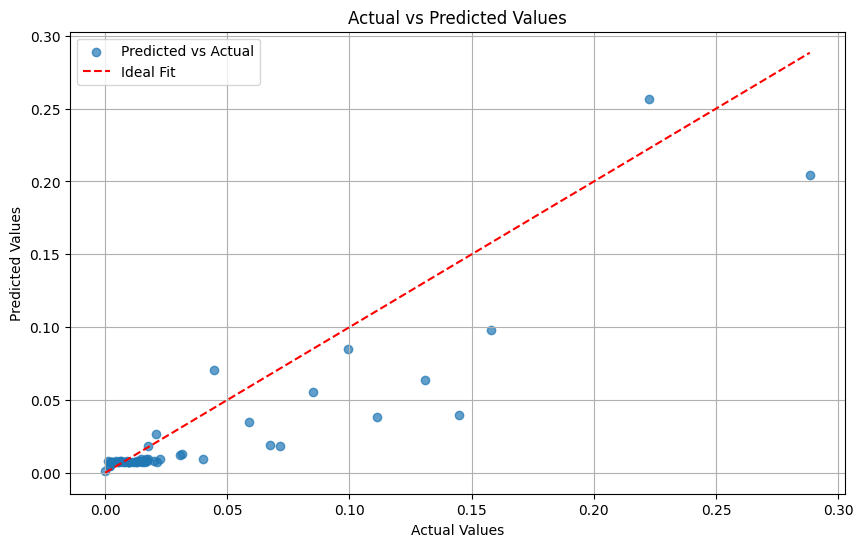

In [15]:
from sklearn.metrics import mean_squared_error

# Ensure the input data is reshaped properly
X_train = np.array(X_train).reshape(X_train.shape[0], -1)
X_val = np.array(X_val).reshape(X_val.shape[0], -1)
X_test = np.array(X_test).reshape(X_test.shape[0], -1)

# Ensure y_train, y_val, and y_test are reshaped properly
y_train = np.array(y_train).reshape(-1, 1)
y_val = np.array(y_val).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

# Define the ANN model
model_ann = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

# Compile the model
model_ann.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history_ann = model_ann.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=32,
    verbose=1
)

# Predict on the test set
y_test_pred_ann = model_ann.predict(X_test)

# Evaluate the model
test_loss, test_mae = model_ann.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Calculate RMSE
test_rmse_ann = np.sqrt(mean_squared_error(y_test, y_test_pred_ann))
print(f"Test RMSE: {test_rmse_ann}")

import matplotlib.pyplot as plt

# Create analysis DataFrame from predictions and actual values
analysis_df = pd.DataFrame()
analysis_df['test_actual'] = y_test.ravel()
analysis_df['test_pred'] = y_test_pred_ann.ravel()



# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(analysis_df['test_actual'], analysis_df['test_pred'], alpha=0.7, label='Predicted vs Actual')
plt.plot([analysis_df['test_actual'].min(), analysis_df['test_actual'].max()],
         [analysis_df['test_actual'].min(), analysis_df['test_actual'].max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Save this DataFrame for later use in the pipeline
analysis_df.to_csv('demand_prediction_results1.csv', index=False)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,685 (30.02 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,124 (20.02 KB)

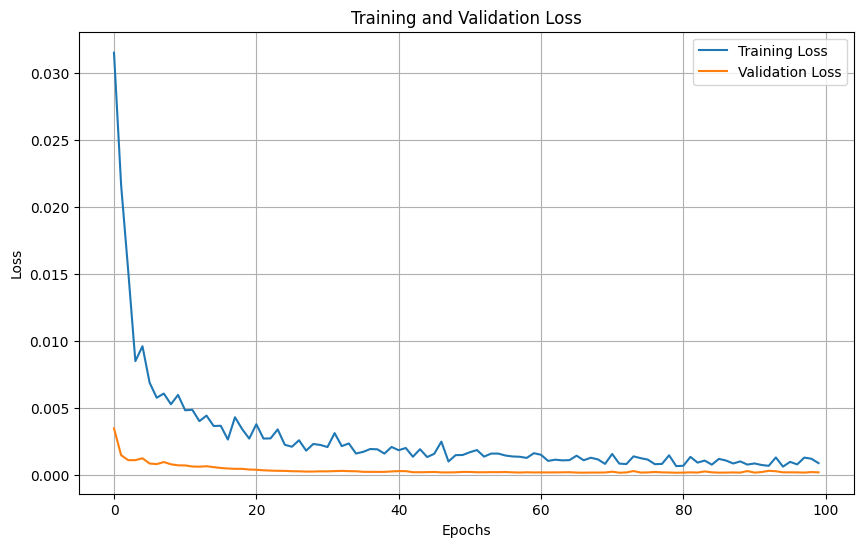

Model saved successfully!


In [ ]:
model_ann.summary()

import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_ann.history['loss'], label='Training Loss')
plt.plot(history_ann.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
#model_ann.save(r'E:\Projects Kgp\IIM Mumbai Task\Facility_layout_optimization\Models\model_ann.keras')
#print("Model saved successfully!")

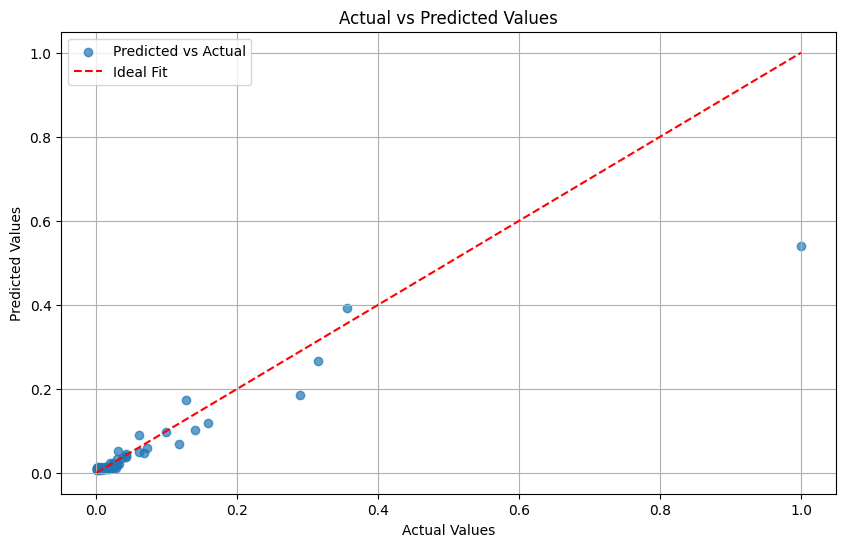

In [96]:
import matplotlib.pyplot as plt

# Create analysis DataFrame from predictions and actual values
analysis_df = pd.DataFrame()
analysis_df['test_actual'] = y_test.ravel()
analysis_df['test_pred'] = y_test_pred_ann.ravel()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(analysis_df['test_actual'], analysis_df['test_pred'], alpha=0.7, label='Predicted vs Actual')
plt.plot([analysis_df['test_actual'].min(), analysis_df['test_actual'].max()],
         [analysis_df['test_actual'].min(), analysis_df['test_actual'].max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
model = Sequential([
    # Dense(16, activation='sigmoid', input_shape=(6,)),
    Dense(16, activation='sigmoid', input_shape=(6,), kernel_regularizer=regularizers.l2(0.01)),
    # Dropout(0.1),
    # Dense(16, activation='sigmoid'),    
    Dense(16, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)),    
    # Dropout(0.1),
    Dense(1, activation='linear')])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 16)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401 (1.57 KB)

 Trainable params: 401 (1.57 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(learning_rate=lr_adam),
    loss=tensorflow.keras.losses.MeanSquaredError())
    # loss=tensorflow.keras.losses.MeanAbsoluteError())

model_wrapper = lm.ModelWrapper(
    tensorflow.keras.models.clone_model(model))

model_wrapper.compile(
    optimizer=tensorflow.keras.optimizers.SGD(learning_rate=lr_sgd),
    # loss=lm.MeanSquaredError())
    loss=lm.SumSquaredError())

early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')

In [47]:
print("Train using Adam")
t1_start = time.perf_counter()
history_adam = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=ep, callbacks=[early_stopping], batch_size=bsize)
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)


Train using Adam
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2601 - val_loss: 0.2209
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2236 - val_loss: 0.1989
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2027 - val_loss: 0.1808
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1900 - val_loss: 0.1602
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1634 - val_loss: 0.1426
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1444 - val_loss: 0.1279
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1330 - val_loss: 0.1131
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1204 - val_loss: 0.1001
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1071 - val_loss: 0.0891
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0946 - val_loss: 0.0787
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0811 - val_loss: 0.0697
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.075

In [48]:
def get_pred(feats, model):
    pred = model.predict(feats)
    pred[pred < 0] = 1e-5   ## sometimes model when generating minimum value as demand do generate a -ve value
    
    return pred

In [50]:
train_pred_adam = get_pred(X_train, model)
test_pred_adam = get_pred(X_test, model)
val_pred_adam = get_pred(X_val, model)

#train_pred_lm = get_pred(X_train, model_wrapper)
#test_pred_lm = get_pred(X_test, model_wrapper)
#val_pred_lm = get_pred(X_val, model_wrapper)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [51]:
train_rmsle_adam = np.sqrt(mean_squared_log_error(y_train, train_pred_adam))
test_rmsle_adam = np.sqrt(mean_squared_log_error(y_test,test_pred_adam))
val_rmsle_adam = np.sqrt(mean_squared_log_error(y_val, val_pred_adam))

#train_rmsle_lm = np.sqrt(mean_squared_log_error(y_train, train_pred_lm))
#test_rmsle_lm = np.sqrt(mean_squared_log_error(y_test, test_pred_lm))
#val_rmsle_lm = np.sqrt(mean_squared_log_error(y_val, val_pred_lm))

In [52]:
train_ER_adam = 100*sum(np.abs(y_train - train_pred_adam))/sum(y_train)
test_ER_adam = 100*sum(np.abs(y_test - test_pred_adam))/sum(y_test)
val_ER_adam = 100*sum(np.abs(y_val - val_pred_adam))/sum(y_val)

#train_ER_lm = 100*sum(np.abs(y_train - train_pred_lm))/sum(y_train)
#test_ER_lm = 100*sum(np.abs(y_test - test_pred_lm))/sum(y_test)
#val_ER_lm = 100*sum(np.abs(y_val - val_pred_lm))/sum(y_val)

In [53]:
print('TRAIN--TEST--VAL')
print('RMSLE_ADAM')
print(train_rmsle_adam, test_rmsle_adam, val_rmsle_adam)
#print('RMSLE_LM')
#print(train_rmsle_lm, test_rmsle_lm, val_rmsle_lm)

print('\nTRAIN--TEST--VAL')
print('ER_ADAM')
print(train_ER_adam, test_ER_adam, val_ER_adam)
#print('ER_LM')
#print(train_ER_lm, test_ER_lm, val_ER_lm )

TRAIN--TEST--VAL
RMSLE_ADAM
0.07745614664664718 0.051461487065938775 0.04450363325282729

TRAIN--TEST--VAL
ER_ADAM
[120.87330651] [114.56296995] [155.29983008]


<Axes: >

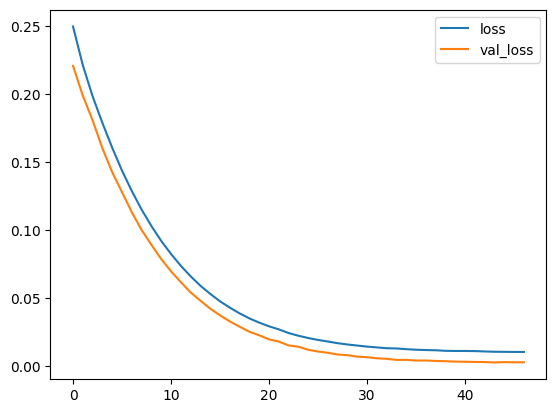

In [54]:
pd.DataFrame(history_adam.history)[['loss', 'val_loss']].plot()

In [61]:
results = pd.DataFrame(columns=['batch_size', 'Epochs', 'train_rmsle_adam', 'test_rmsle_adam', 'val_rmsle_adam', 'train_ER_adam', 'test_ER_adam', 'val_ER_adam'])
#results = pd.read_csv('../Results/hyp_tuning.csv')
tmp = pd.DataFrame([{'batch_size':bsize, 'Epochs' : ep, 'train_rmsle_adam' : train_rmsle_adam, 'test_rmsle_adam': test_rmsle_adam, 'val_rmsle_adam': val_rmsle_adam, \
    'train_ER_adam':train_ER_adam, 'test_ER_adam':test_ER_adam, 'val_ER_adam':val_ER_adam}])
results = pd.concat([results, tmp])

results.to_csv('E:\Projects Kgp\IIM Mumbai Task\Facility_layout_optimization\Results\hyp_tuning.csv', index=False)

In [ ]:
# Create analysis DataFrame from predictions and actual values 
analysis_df = pd.DataFrame()
analysis_df['train_actual'] = pd.DataFrame(scaler.inverse_transform(y_train))
analysis_df['train_pred'] = pd.DataFrame(scaler.inverse_transform(train_pred_adam))
analysis_df['test_actual'] = pd.DataFrame(scaler.inverse_transform(y_test))
analysis_df['test_pred'] = pd.DataFrame(scaler.inverse_transform(test_pred_adam))
analysis_df['val_actual'] = pd.DataFrame(scaler.inverse_transform(y_val))
analysis_df['val_pred'] = pd.DataFrame(scaler.inverse_transform(val_pred_adam))

# Save this DataFrame for later use in the pipeline
analysis_df.to_csv('demand_prediction_results.csv', index=False)



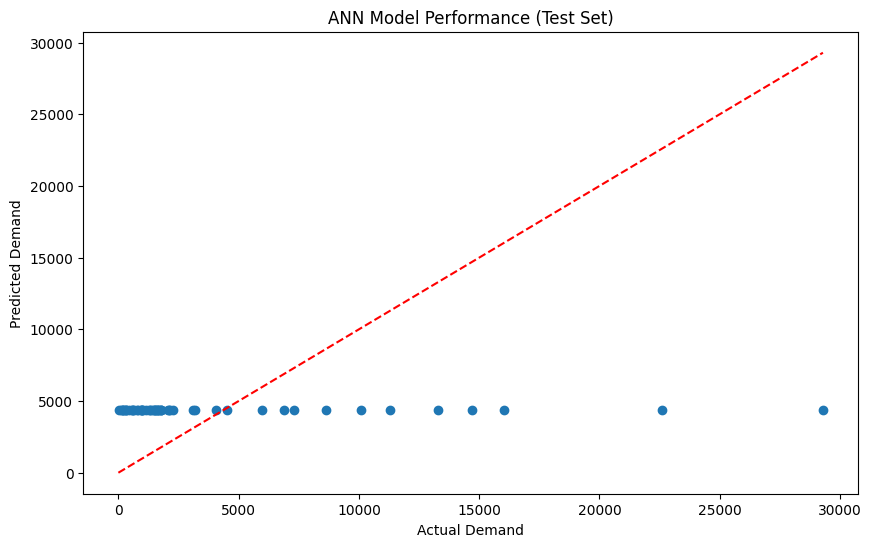

In [73]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(analysis_df['test_actual'], analysis_df['test_pred'])
plt.plot([0, analysis_df['test_actual'].max()], [0, analysis_df['test_actual'].max()], 'r--')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.title('ANN Model Performance (Test Set)')
plt.savefig('demand_prediction_scatter.png')


In [64]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize the XGBoost regressor
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)

# Train the model on training data and validate with validation data
xgb_model.fit(X_train, y_train.ravel(), eval_set=[(X_val, y_val.ravel())], verbose=False)

# Predict on the test set
y_test_pred = xgb_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test.ravel(), y_test_pred))
print(f"RMSE on test set: {rmse}")

RMSE on test set: 0.016302812461210014


In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=42)

# Initialize the base models
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
svm = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Train the base models
rfr.fit(X_train, y_train)
svm.fit(X_train, y_train)

# Get predictions from the base models
rfr_pred = rfr.predict(X_test).reshape(-1, 1)  # Predictions from RandomForestRegressor
svm_pred = svm.predict(X_test).reshape(-1, 1)  # Predictions from SVR

# Stack the predictions as input for the meta-model
stacked_features = np.hstack((rfr_pred, svm_pred))

# Initialize the meta-model (XGBoost)
xgb_meta = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# Train the meta-model on the stacked features
xgb_meta.fit(stacked_features, y_test)

# Predict on the test set using the stacked model
stacked_test_features = np.hstack((rfr.predict(X_test).reshape(-1, 1),
                                   svm.predict(X_test).reshape(-1, 1)))
y_pred = xgb_meta.predict(stacked_test_features)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE) of the stacked model: {rmse}")

Root Mean Squared Error (RMSE) of the stacked model: 0.0014775762279708336


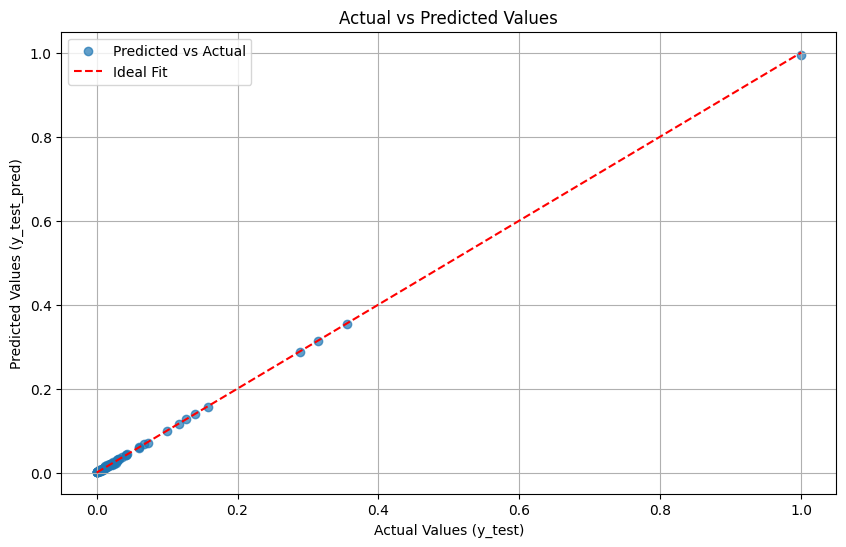

In [66]:
import matplotlib.pyplot as plt

# Plot y_test vs y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_test_pred)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()